In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Load Diabetes Dataset

In [2]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/DSC 256R/diabetic_data.csv"

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path, na_values='?', delimiter=',')

Mounted at /content/drive


<ipython-input-2-b497c1de6048>:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, na_values='?', delimiter=',')


# Exploratory Data Analysis

In [3]:
# Display basic information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
# Summary statistics for numerical columns
print(data.describe())

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.00000

In [5]:
# Display the first few rows
print(data.head())

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

In [6]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values Per Column:\n", missing_values[missing_values > 0])

Missing Values Per Column:
 race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64


In [7]:
# Check for unique values to identify potential data issues
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

encounter_id: 101766 unique values
patient_nbr: 71518 unique values
race: 5 unique values
gender: 3 unique values
age: 10 unique values
weight: 9 unique values
admission_type_id: 8 unique values
discharge_disposition_id: 26 unique values
admission_source_id: 17 unique values
time_in_hospital: 14 unique values
payer_code: 17 unique values
medical_specialty: 72 unique values
num_lab_procedures: 118 unique values
num_procedures: 7 unique values
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient: 21 unique values
diag_1: 716 unique values
diag_2: 748 unique values
diag_3: 789 unique values
number_diagnoses: 16 unique values
max_glu_serum: 3 unique values
A1Cresult: 3 unique values
metformin: 4 unique values
repaglinide: 4 unique values
nateglinide: 4 unique values
chlorpropamide: 4 unique values
glimepiride: 4 unique values
acetohexamide: 2 unique values
glipizide: 4 unique values
glyburide: 4 unique values
tolbutamide:

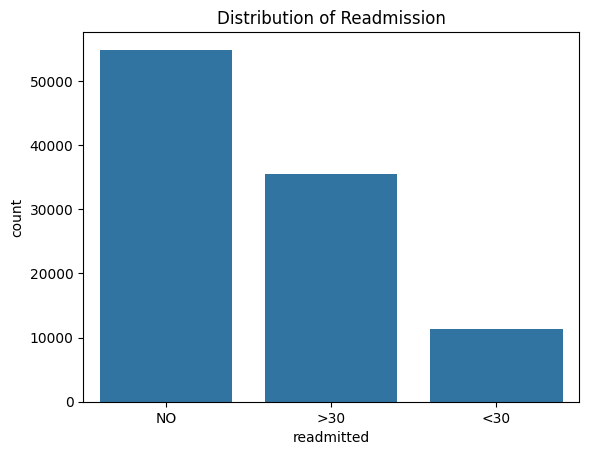

In [8]:
# Distribution of target variable (readmission)
sns.countplot(x='readmitted', data=data)
plt.title('Distribution of Readmission')
plt.show()

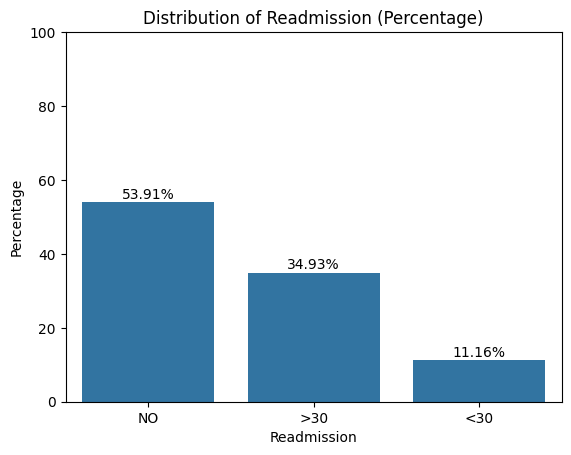

In [9]:
# Calculate the percentage distribution of the target variable
readmitted_percent = data['readmitted'].value_counts(normalize=True) * 100

# Plot the distribution
sns.barplot(x=readmitted_percent.index, y=readmitted_percent.values)
plt.title('Distribution of Readmission (Percentage)')
plt.ylabel('Percentage')
plt.xlabel('Readmission')
plt.ylim(0, 100)

# Annotate the bars with percentages
for i, percentage in enumerate(readmitted_percent.values):
    plt.text(x=i, y=percentage + 1, s=f'{percentage:.2f}%', ha='center')

plt.show()

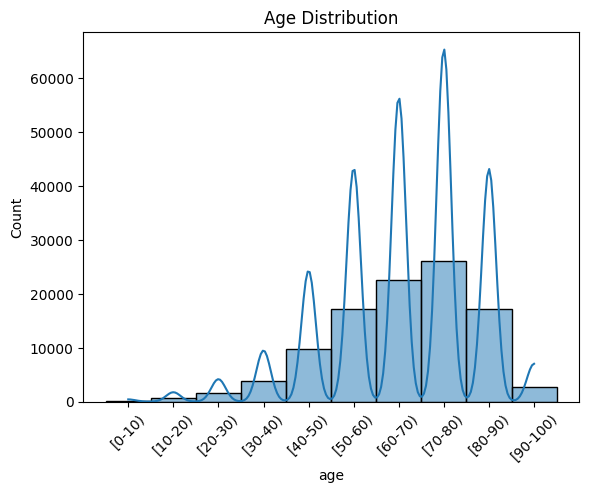

In [10]:
# Distribution of age
sns.histplot(data['age'], bins=10, kde=True)
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show()

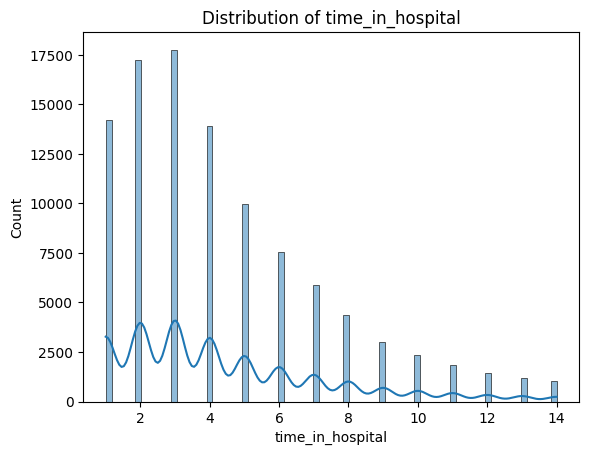

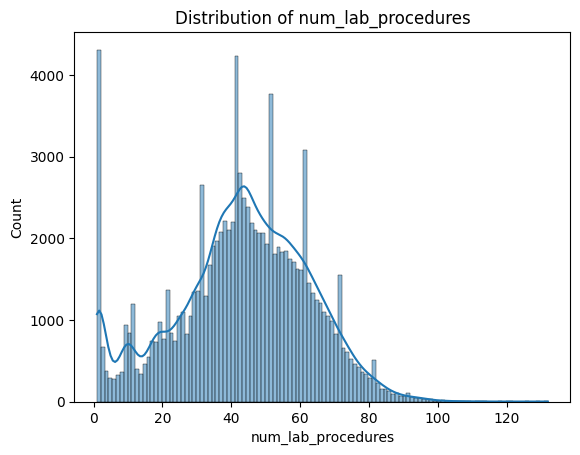

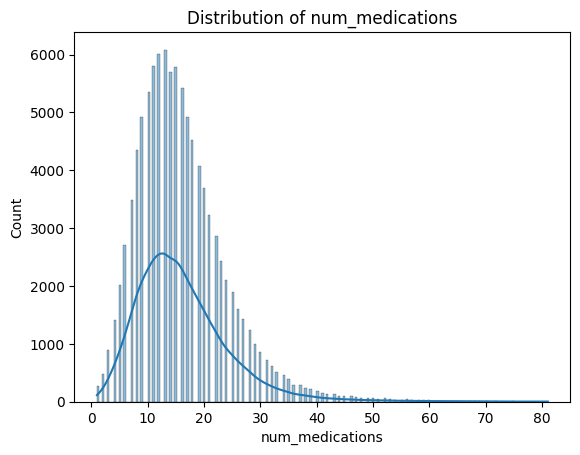

In [ ]:
# Plot distribution of numeric variables
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_medications']
for col in numerical_cols:
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

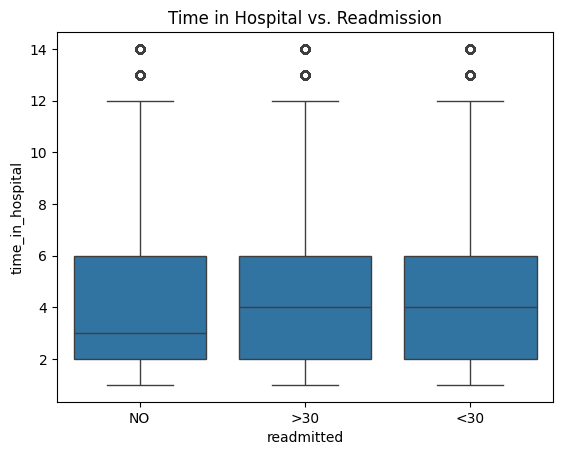

In [ ]:
# Length of stay vs. readmission
sns.boxplot(x='readmitted', y='time_in_hospital', data=data)
plt.title('Time in Hospital vs. Readmission')
plt.show()

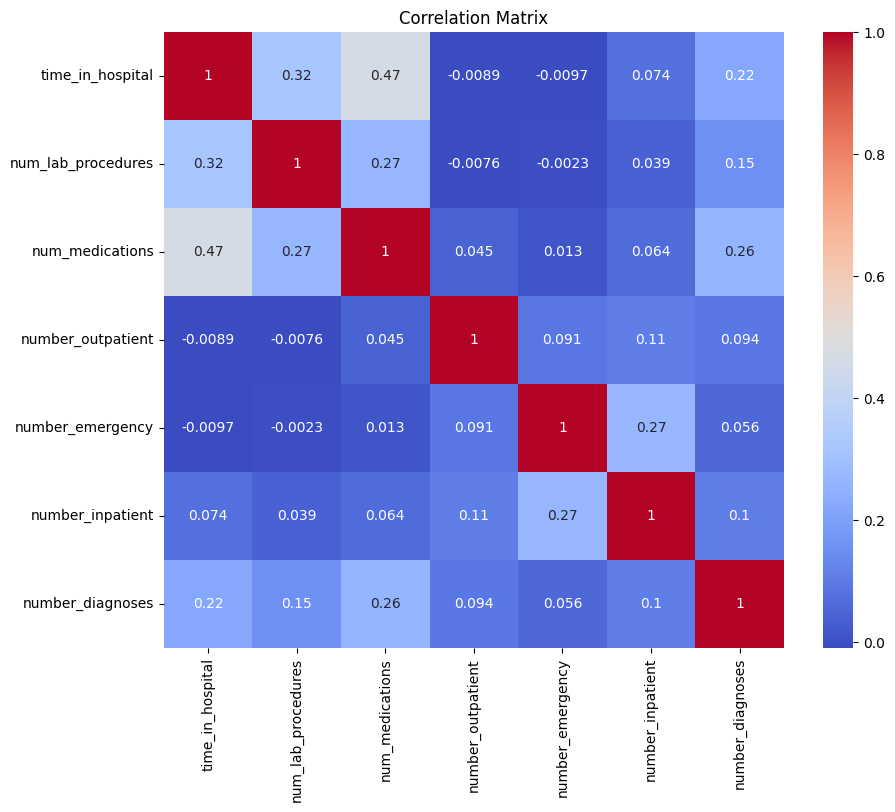

In [ ]:
# Correlation heatmap for numeric features
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_medications',
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
correlation_matrix = data[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

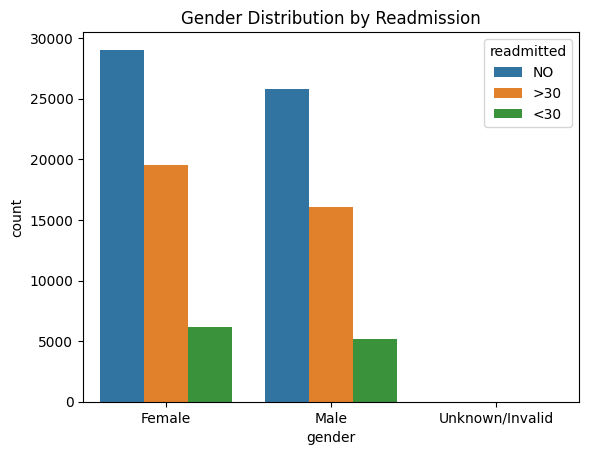

In [ ]:
# Categorical variable vs target
sns.countplot(x='gender', hue='readmitted', data=data)
plt.title("Gender Distribution by Readmission")
plt.show()

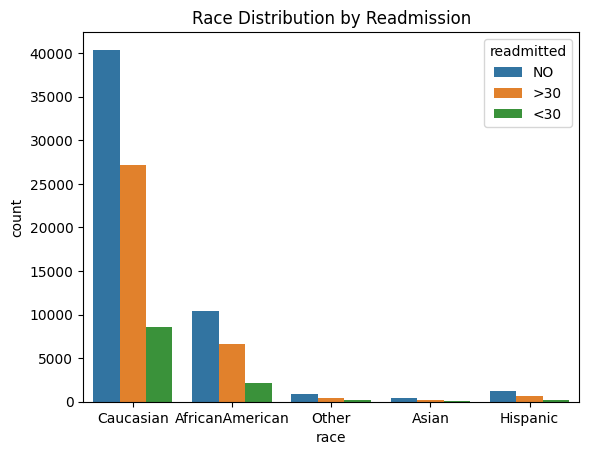

In [ ]:
# Categorical variable vs target
sns.countplot(x='race', hue='readmitted', data=data)
plt.title("Race Distribution by Readmission")
plt.show()

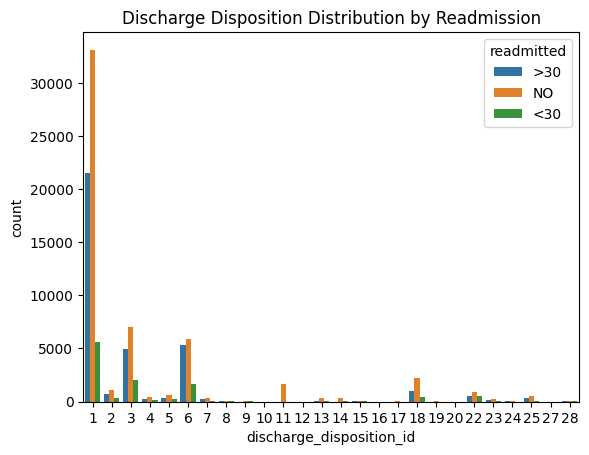

In [ ]:
# Categorical variable vs target
sns.countplot(x='discharge_disposition_id', hue='readmitted', data=data)
plt.title("Discharge Disposition Distribution by Readmission")
plt.show()

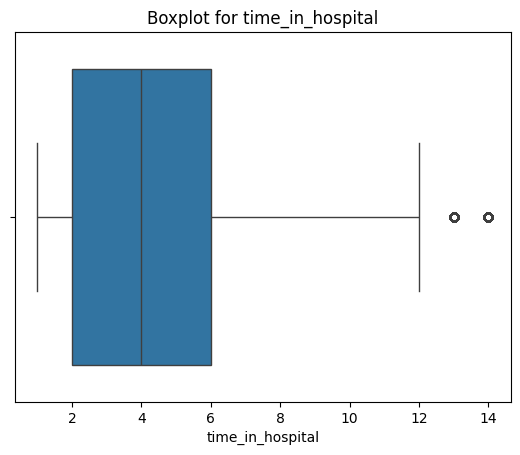

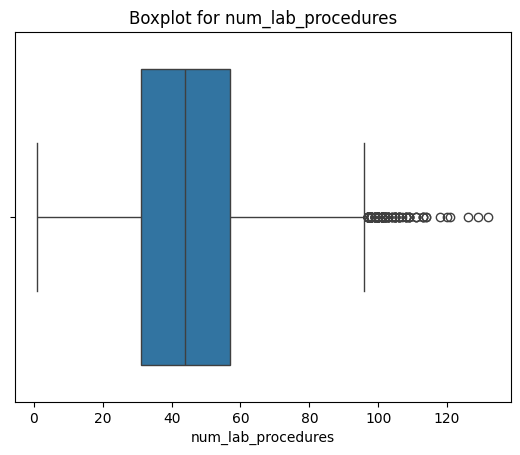

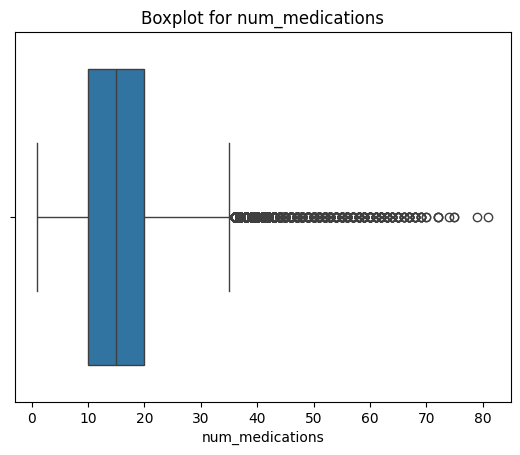

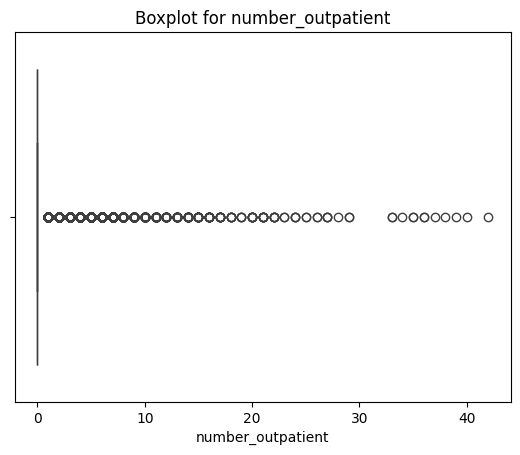

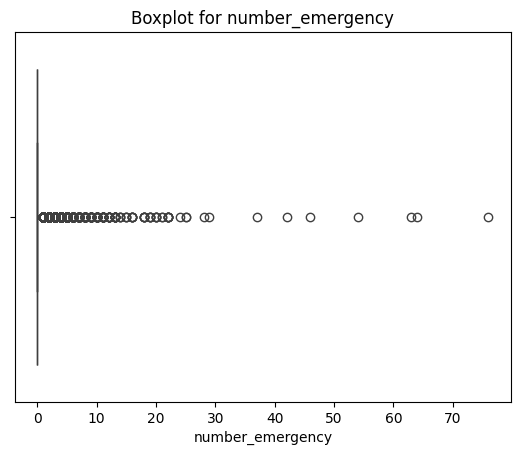

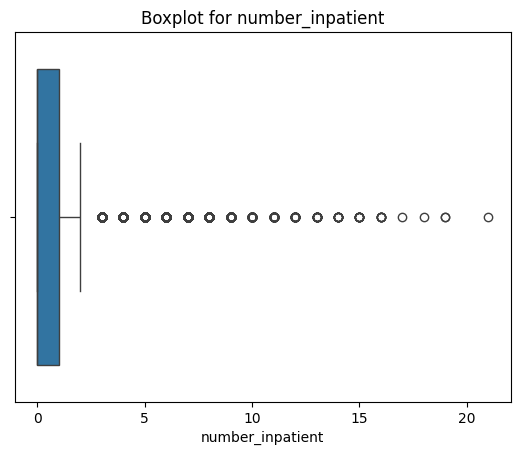

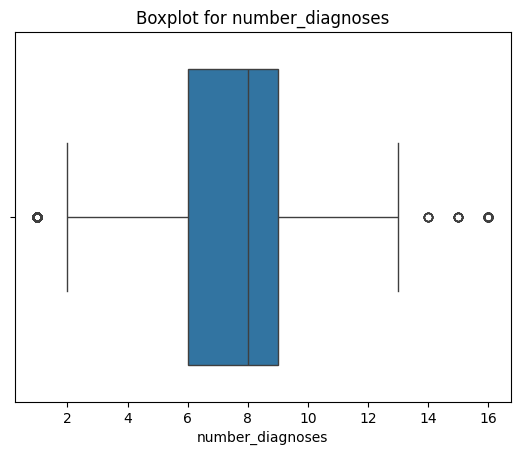

In [ ]:
# Boxplot for outliers in numerical variables
for col in numerical_cols:
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [ ]:
# Replace missing values for specific columns
data['race'] = data['race'].fillna('Unknown')
data['medical_specialty'] = data['medical_specialty'].fillna('Other')
data['diag_1'] = data['diag_1'].fillna('Unknown')
data['diag_2'] = data['diag_2'].fillna('Unknown')
data['diag_3'] = data['diag_3'].fillna('Unknown')
data.drop(['weight', 'payer_code'], axis=1, inplace=True)

data.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,Other,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,Other,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,Other,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,Other,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
admission_type_mapping = {
    1: 'Emergency', 2: 'Urgent', 3: 'Elective',
    4: 'Newborn', 5: 'Not Available', 6: 'NULL', 7: 'Trauma Center', 8: 'Not Mapped'
}
data['admission_type'] = data['admission_type_id'].map(admission_type_mapping)
data.drop('admission_type_id', axis=1, inplace=True)

In [ ]:
data['A1Cresult'] = data['A1Cresult'].fillna(0)
data['max_glu_serum'] = data['max_glu_serum'].fillna(0)

In [ ]:
# Replacae the A1C and max_glu_serum values with numbers
data['HbA1c_measurement'] = data['A1Cresult'].replace({'Norm': 1, '>7': 1, '>8': 1})
data['max_glu_serum_measurement'] = data['max_glu_serum'].replace({'Norm': 1, '>200': 1, '>300': 1})

data.drop('A1Cresult', axis=1, inplace=True)
data.drop('max_glu_serum', axis=1, inplace=True)

<ipython-input-22-126dbe36b1a5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['HbA1c_measurement'] = data['A1Cresult'].replace({'Norm': 1, '>7': 1, '>8': 1})
<ipython-input-22-126dbe36b1a5>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['max_glu_serum_measurement'] = data['max_glu_serum'].replace({'Norm': 1, '>200': 1, '>300': 1})


In [ ]:
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [ ]:
data['chronic_condition_count'] = data['number_diagnoses']
data['hospital_interaction'] = data['number_inpatient'] + data['number_outpatient'] + data['number_emergency']

In [ ]:
data.head()

,encounter_id,patient_nbr,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type,HbA1c_measurement,max_glu_serum_measurement,chronic_condition_count,hospital_interaction
0,2278392,8222157,Caucasian,Female,[0-10),25,1,1,Pediatrics-Endocrinology,41,...,No,No,No,No,0,NULL,0,0,1,0
1,149190,55629189,Caucasian,Female,[10-20),1,7,3,Other,59,...,No,No,Ch,Yes,0,Emergency,0,0,9,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,7,2,Other,11,...,No,No,No,Yes,0,Emergency,0,0,6,3
3,500364,82442376,Caucasian,Male,[30-40),1,7,2,Other,44,...,No,No,Ch,Yes,0,Emergency,0,0,7,0
4,16680,42519267,Caucasian,Male,[40-50),1,7,1,Other,51,...,No,No,Ch,Yes,0,Emergency,0,0,5,0


In [ ]:
# Remove outliers in `time_in_hospital` using IQR
Q1 = data['time_in_hospital'].quantile(0.25)
Q3 = data['time_in_hospital'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['time_in_hospital'] >= lower_bound) & (data['time_in_hospital'] <= upper_bound)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize numerical features
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                  'number_inpatient', 'number_outpatient', 'number_emergency', 'number_diagnoses', 'chronic_condition_count', 'hospital_interaction']
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

<ipython-input-27-f01cb85b3cad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


In [ ]:
# Impute missing categorical values
categorical_cols = ['race', 'gender', 'admission_type', 'medical_specialty', 'max_glu_serum_measurement', 'HbA1c_measurement']
for col in categorical_cols:
    data[col] = data[col].fillna('Unknown')

# Impute missing numerical values
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].median())

In [ ]:
# Separate features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# One-hot encode categorical variables, ignoring unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

# Transform the training and test sets
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Apply SMOTE on the preprocessed training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# Check the distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_smote).value_counts())

Before SMOTE: readmitted
0    70753
1     8858
Name: count, dtype: int64
After SMOTE: readmitted
0    70753
1    70753
Name: count, dtype: int64


In [ ]:
# Function to evaluate model performance
def evaluate_model(y_test, y_pred, y_proba):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_proba))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_smote, y_train_smote)
y_pred_log_reg = log_reg.predict(X_test_encoded)
y_proba_log_reg = log_reg.predict_proba(X_test_encoded)[:, 1]
evaluate_model(y_test, y_pred_log_reg, y_proba_log_reg)

Accuracy: 0.6635683062854846
Precision: 0.16150475902704337
Recall: 0.48261851015801355
F1-Score: 0.242019470228662
AUC-ROC: 0.6278466966419698

Confusion Matrix:
 [[12138  5550]
 [ 1146  1069]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.69      0.78     17688
           1       0.16      0.48      0.24      2215

    accuracy                           0.66     19903
   macro avg       0.54      0.58      0.51     19903
weighted avg       0.83      0.66      0.72     19903



In [ ]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_smote.toarray(), y_train_smote)  # SMOTE data converted to dense array
y_pred_nb = nb.predict(X_test_encoded.toarray())
y_proba_nb = nb.predict_proba(X_test_encoded.toarray())[:, 1]
evaluate_model(y_test, y_pred_nb, y_proba_nb)

Accuracy: 0.13580867205948852
Precision: 0.11261051651931131
Recall: 0.983295711060948
F1-Score: 0.2020783076637595
AUC-ROC: 0.5066229748037975

Confusion Matrix:
 [[  525 17163]
 [   37  2178]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.03      0.06     17688
           1       0.11      0.98      0.20      2215

    accuracy                           0.14     19903
   macro avg       0.52      0.51      0.13     19903
weighted avg       0.84      0.14      0.07     19903



In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_encoded)
y_proba_rf = rf.predict_proba(X_test_encoded)[:, 1]
evaluate_model(y_test, y_pred_rf, y_proba_rf)

Accuracy: 0.8752951816309099
Precision: 0.2026726057906459
Recall: 0.04108352144469526
F1-Score: 0.06831831831831832
AUC-ROC: 0.5824119832808051

Confusion Matrix:
 [[17330   358]
 [ 2124    91]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     17688
           1       0.20      0.04      0.07      2215

    accuracy                           0.88     19903
   macro avg       0.55      0.51      0.50     19903
weighted avg       0.81      0.88      0.84     19903



In [ ]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test_encoded)
y_proba_xgb = xgb.predict_proba(X_test_encoded)[:, 1]
evaluate_model(y_test, y_pred_xgb, y_proba_xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8879063457770185
Precision: 0.375
Recall: 0.010835214446952596
F1-Score: 0.02106186924089513
AUC-ROC: 0.60879314692697

Confusion Matrix:
 [[17648    40]
 [ 2191    24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     17688
           1       0.38      0.01      0.02      2215

    accuracy                           0.89     19903
   macro avg       0.63      0.50      0.48     19903
weighted avg       0.83      0.89      0.84     19903



In [ ]:
# Majority Class Predictor
majority_class = y_train.value_counts().idxmax()
y_pred_majority = [majority_class] * len(y_test)
print("\nMajority Class Predictor Performance:")
print(classification_report(y_test, y_pred_majority))
print("AUC-ROC: N/A (no probabilities available for majority class predictor)")


Majority Class Predictor Performance:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17688
           1       0.00      0.00      0.00      2215

    accuracy                           0.89     19903
   macro avg       0.44      0.50      0.47     19903
weighted avg       0.79      0.89      0.84     19903

AUC-ROC: N/A (no probabilities available for majority class predictor)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Random Guesser
np.random.seed(42)
y_pred_random = np.random.randint(0, 2, size=len(y_test))
y_proba_random = np.random.rand(len(y_test))
evaluate_model(y_test, y_pred_random, y_proba_random)

Accuracy: 0.5024870622519219
Precision: 0.11305748515050841
Recall: 0.5069977426636569
F1-Score: 0.18488640105367138
AUC-ROC: 0.5068584330553267

Confusion Matrix:
 [[8878 8810]
 [1092 1123]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.50      0.64     17688
           1       0.11      0.51      0.18      2215

    accuracy                           0.50     19903
   macro avg       0.50      0.50      0.41     19903
weighted avg       0.80      0.50      0.59     19903



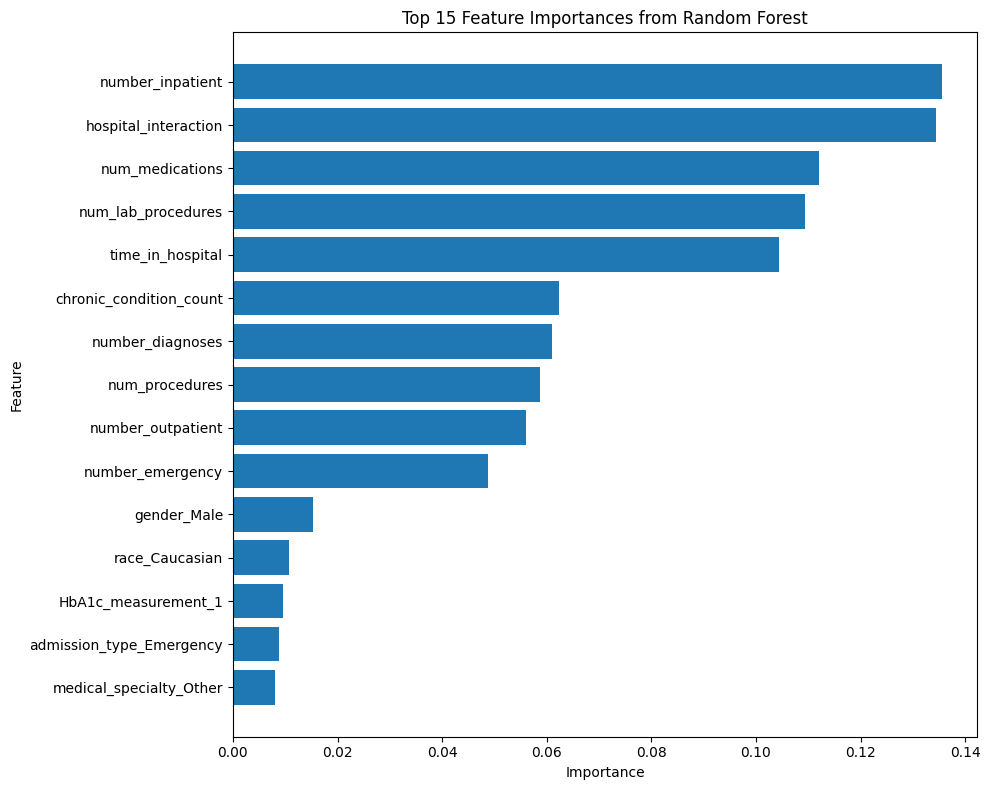

In [ ]:
# Extract feature importances
feature_importances = rf.feature_importances_

# Retrieve feature names
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(categorical_feature_names) + numerical_cols

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 15 features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Weighted Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft',  # Use soft voting for probabilities
    weights=[1, 2, 3]  # Assign higher weight to XGBoost
)

# Fit the Voting Classifier
voting_clf.fit(X_train_smote, y_train_smote)

# Predict and evaluate using the Voting Classifier
y_pred_voting = voting_clf.predict(X_test_encoded)
y_proba_voting = voting_clf.predict_proba(X_test_encoded)[:, 1]
evaluate_model(y_test, y_pred_voting, y_proba_voting)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8861980605938803
Precision: 0.33766233766233766
Recall: 0.02347629796839729
F1-Score: 0.04390037990713381
AUC-ROC: 0.6164998550240792

Confusion Matrix:
 [[17586   102]
 [ 2163    52]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     17688
           1       0.34      0.02      0.04      2215

    accuracy                           0.89     19903
   macro avg       0.61      0.51      0.49     19903
weighted avg       0.83      0.89      0.84     19903



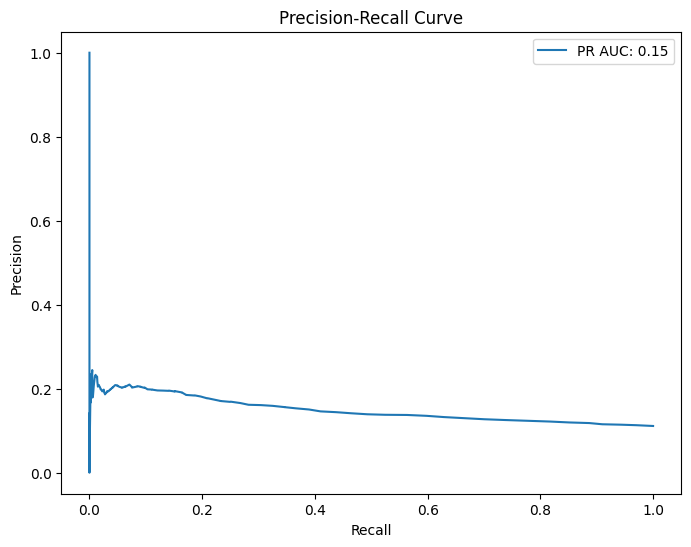

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [{0: 1, 1: 5}, {0: 1, 1: 10}]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Convert sparse matrix to DataFrame or NumPy array
X_train_smote_dense = pd.DataFrame(X_train_smote.toarray())  # Convert to DataFrame
y_train_smote_dense = pd.Series(y_train_smote)  # Ensure y_train is a Series

# Take a subset of training data
X_train_subset = X_train_smote_dense.sample(frac=0.5, random_state=42)
y_train_subset = y_train_smote_dense.loc[X_train_subset.index]  # Match labels to sampled rows

# Perform random search on the subset
random_search.fit(X_train_subset, y_train_subset)

# Best model
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_encoded)
y_proba_rf = best_rf.predict_proba(X_test_encoded)[:, 1]

# Evaluate
print("\nBest Parameters:", random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_rf))

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': {0: 1, 1: 5}}

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     17688
           1       0.24      0.06      0.10      2215

    accuracy                           0.87     19903
   macro avg       0.56      0.52      0.51     19903
weighted avg       0.82      0.87      0.84     19903

AUC-ROC: 0.5821927199626737


In [ ]:
# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf', rf),
        ('xgb', xgb)
    ],
    final_estimator=LogisticRegression(),  # Logistic Regression as meta-model
    cv=3  # Use 3-fold cross-validation
)

# Fit the Stacking Classifier
stacking_clf.fit(X_train_smote, y_train_smote)

# Predict and evaluate using the Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_test_encoded)
y_proba_stacking = stacking_clf.predict_proba(X_test_encoded)[:, 1]

print("\nStacking Classifier Performance:")
print(classification_report(y_test, y_pred_stacking))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_stacking))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:16:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:24:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:24:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:24:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Stacking Classifier Performance:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     17688
           1       0.19      0.04      0.07      2215

    accuracy                           0.87     19903
   macro avg       0.54      0.51      0.50     19903
weighted avg       0.81      0.87      0.84     19903

AUC-ROC: 0.5752508364191764
